In [1]:
from Basics import *
setplot(dark=True)

import Measurements, SHMRs, HMFs, HODs, Profiles, SMFs, ForwardModel

The forward model starts with a dictionary specifying the components that is will require:
- halo mass function
- te stellar mass function 
- stellar-halo mass relation
- halo occupancy distrbution (only if doing it through this method)

all of which are entirely defined in their respective files and simple need to be called and specified.
We also set some general cosmological/astrophysical parameters that will be needed throughtout.

In [2]:
fmoddict = {
    'HMF': {'name':'hmf_package', 'spefs': {'mdef':'SOCritical', 'mfunc':'Tinker08'}},
    'HOD': {'name':'Kou2023', 'spefs': {'sample':'M*>10.8'}},
    'SMF': {'name': 'Gao2023', 'spefs': {'sample':'LRG', 'hemisphere':'south', 'zbin':'bin_1', 'zweight':'True'}},
    'SHMR': {'name': 'Kravstov2014', 'spefs': {'sample': 'M200c'}},
}

cpars = {'hh': 0.7, 'Omega_L': 0.75, 'Omega_m': 0.25, 'Omega_b': 0.044, 'T_CMB': 2.726, 'XH':0.76, 'v_rms':1.06e-3}

The model will also need some basic cosmological functions like H, dA, rho_c, and r200, which can be from anywhere. Here we just take the verison from astropy after setting up a cosmology with our above parameters.

In [3]:
cosmology = astropy.cosmology.LambdaCDM(H0=cpars["hh"]*100, Tcmb0=cpars['T_CMB'], Om0=cpars["Omega_m"], Ode0=cpars["Omega_L"], Ob0=cpars["Omega_b"])

H_func = lambda z: cosmology.H(z).to(u.km/u.s/u.Mpc).value
rhoc_func = lambda z: cosmology.critical_density(z).to(u.Msun/u.Mpc**3).value
dA_func = lambda z: cosmology.angular_diameter_distance(z).value
r200c_func = lambda z, m200c: (m200c/(4/3*np.pi*200*rhoc_func(z)))**(1/3)

Next we load in all of the components needed for our forward model, which will also inform our choices of mass and redshifts arrays. Alternatively, you can just add some custom array for any of these values, as long as the formatting stays consistent to that in the files. We then use these components to construct the first part of our forward model, which takes a survey average of the profile.

In [5]:
SMF = getattr(SMFs, fmoddict['SMF']['name'])(fmoddict['SMF']['spefs'])
gdist = SMF.gdist(**cpars)

msstar, zs = SMF.mstars, SMF.zs
mrange = np.sum(gdist, axis=0)/np.sum(gdist)>1e-3
gdist, msstar = gdist[:, mrange], msstar[mrange]

mshalo = getattr(SHMRs, fmoddict['SHMR']['name'])(fmoddict['SHMR']['spefs']).SHMR(msstar)

# Create a HMF function to use with the HOD
hmf = getattr(HMFs, fmoddict['HMF']['name'])(fmoddict['HMF']['spefs']).HMF(zs, mshalo, **cpars)

# Define an HOD Model used for this method
HOD = getattr(HODs, fmoddict['HOD']['name'])(fmoddict['HOD']['spefs'])


rs = np.logspace(-1, 1, 100)

ave_weight = ForwardModel.weighting(gdist)
ave_HOD = ForwardModel.HODweighting(rs, zs, mshalo, HOD, hmf, r200c_func, H_func, **cpars)

/global/u2/c/cpopik/Capybara/SMFs.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.zdistscale = self.zdistdf.groupby('zbin')[f"{self.zbin}_{self.hemisphere}"].sum().values*self.surveyarea


TypeError: HODweighting() missing 2 required positional arguments: 'r200c_func' and 'H_func'

Next we create a dictionary to define the measurement we want to refer to, as well as the actual forms of the profiles we want to forward model to that measurement.

In [48]:
tszdict = {'Data': {'name':'Liu2025', 'spefs': {'zbin':'1', 'dBeta':'1.2'}},
    'onehalo': {'name':'Amodeo2021', 'spefs': {'model':'GNFW'}},
    'twohalo': {'name':'Amodeo2021', 'spefs': {'model':'GNFW'}},
    }

kszdict = {'Data': {'name':'Hadzhiyska2025', 'spefs': {'zbin':'1', 'sample':'main', 'corr':'corrected','zoutcut':'nocut'}},
    'onehalo': {'name':'Amodeo2021', 'spefs': {'model':'GNFW'}},
    'twohalo': {'name':'Amodeo2021', 'spefs': {'model':'GNFW'}},
    }

We load in the data from the file and relevant information on its freq, beam, etc, all of which we then use to define a projection/beam convolution function that our survey averaged profile will be an input to.

In [51]:
tSZdata = getattr(Measurements, tszdict['Data']['name'])(tszdict['Data']['spefs'])
tSZdata.tSZdata_in_muK(cpars['T_CMB'])

tSZproj = ForwardModel.project_Hankel(rs, tSZdata.thetas, dA_func(SMF.zave(**cpars)), tSZdata.beam_data, tSZdata.beam_ells, tSZdata.resp_data, tSZdata.resp_ells)
tSZsign = ForwardModel.Pth_to_muK(freq=tSZdata.freq, **cpars)


kSZdata = getattr(Measurements, kszdict['Data']['name'])(kszdict['Data']['spefs'])

kSZproj = ForwardModel.project_Hankel(rs, kSZdata.thetas, dA_func(SMF.zave(**cpars)), kSZdata.beam_data, kSZdata.beam_ells, kSZdata.resp_data, kSZdata.resp_ells)
kSZsign = ForwardModel.rho_to_muK(freq=kSZdata.freq, **cpars)


We define our profiles, both the one-halo and two-halo component, and then sum to get the total. These can also be replaced with any input array of profile, so long as it matches the formatting and mass/redshift dimensionalities.

In [56]:
# Define a pressure and density profile
Pth1h = getattr(Profiles, tszdict['onehalo']['name'])(tszdict['onehalo']['spefs']).Pth1h(rs, zs, mshalo, rhoc_func, r200c_func, **cpars)
Pth2h = getattr(Profiles, tszdict['twohalo']['name'])(tszdict['twohalo']['spefs']).Pth2h(rs, zs, mshalo)
Pth = lambda params={}: Pth1h(params)+Pth2h(params)

rho1h = getattr(Profiles, kszdict['onehalo']['name'])(kszdict['onehalo']['spefs']).rho1h(rs, zs, mshalo, rhoc_func, r200c_func, **cpars)
rho2h = getattr(Profiles, kszdict['twohalo']['name'])(kszdict['twohalo']['spefs']).rho2h(rs, zs, mshalo)
rho = lambda params={}: rho1h(params)+rho2h(params)

Now with all of our forward model functions defined, the process of going from any input profile is simple and easy, and only dependent on some input parameters that define that profile.

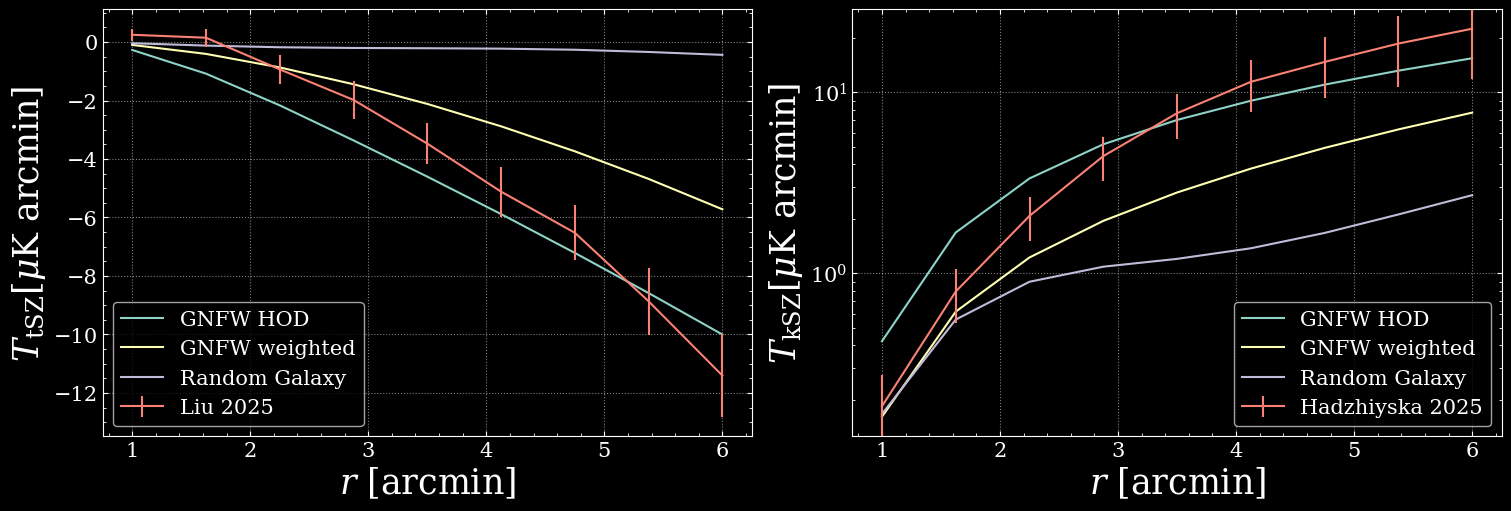

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')
axs[0].set(xlabel=r'$r$ [arcmin]', ylabel=r'$T_\text{tSZ} [\mu \text{K arcmin}]$')
axs[1].set(xlabel=r'$r$ [arcmin]', ylabel=r'$T_\text{kSZ} [\mu \text{K arcmin}]$', yscale='log')


axs[0].plot(tSZdata.thetas, tSZsign(tSZproj(ave_HOD(Pth({'P0':1, 'beta_t':3.5}), cpars))), label='GNFW HOD')
axs[0].plot(tSZdata.thetas, tSZsign(tSZproj(ave_weight(Pth()))), label='GNFW weighted')
axs[0].plot(tSZdata.thetas, tSZsign(tSZproj(pths_sim)), label='Random Galaxy')
axs[0].errorbar(tSZdata.thetas, tSZdata.tSZdata, np.diag(tSZdata.tSZcov)**0.5, label='Liu 2025')

axs[1].plot(kSZdata.thetas, kSZsign(kSZproj(ave_HOD(rho(), cpars))), label='GNFW HOD')
axs[1].plot(kSZdata.thetas, kSZsign(kSZproj(ave_weight(rho()))), label='GNFW weighted')
axs[1].plot(kSZdata.thetas, kSZsign(kSZproj(rhos_sim)), label='Random Galaxy')

axs[1].errorbar(kSZdata.thetas, kSZdata.kSZdata, np.diag(kSZdata.kSZcov)**0.5, label='Hadzhiyska 2025')

axs[0].legend(), axs[1].legend(); plt.show()

In [59]:
rhos_sim = np.array([0.00000000e+00, 0.00000000e+00, 3.23705634e-27, 1.56168858e-27,
       4.91244157e-27, 5.21580669e-27, 6.38216246e-27, 5.70257482e-27,
       4.12217423e-27, 2.33994805e-27, 1.27096728e-27, 8.04106407e-28,
       3.44132275e-28, 2.88597645e-28, 1.87161756e-28, 2.24149017e-28,
       2.29002389e-28, 2.29382382e-28, 2.43134868e-28, 1.86100842e-28,
       2.86294376e-28, 1.81634456e-28, 2.16678369e-28, 2.19674323e-28,
       2.36151784e-28, 2.43873184e-28, 1.41361124e-28, 1.41445148e-28,
       1.22321137e-28, 1.06014661e-28, 7.01056510e-29, 4.03953593e-29,
       3.15549963e-29, 2.17803688e-29, 1.68568303e-29, 1.13405189e-29,
       7.89355462e-30, 4.38655348e-30, 3.12446110e-30, 2.37524525e-30,
       1.97745749e-30, 2.14973063e-30, 3.32091724e-30, 1.93460365e-30,
       2.53382894e-30, 2.02206927e-30, 1.54370781e-30, 1.35169049e-30,
       1.34329254e-30, 1.20058152e-30])

pths_sim = np.array([0.00000000e+00, 0.00000000e+00, 2.05314805e-12, 6.94251223e-13,
       2.86421140e-12, 1.97639960e-12, 6.43160187e-12, 1.77639342e-12,
       2.20108092e-12, 6.59821541e-13, 5.43241396e-13, 7.55490390e-14,
       9.40319103e-14, 4.08399105e-14, 3.33190822e-14, 3.19031824e-14,
       5.08679567e-14, 4.13141708e-14, 5.63702278e-14, 5.07182323e-14,
       6.17000004e-14, 6.61052150e-14, 7.84620564e-14, 8.55376704e-14,
       7.64423241e-14, 5.40675911e-14, 3.72300205e-14, 3.23169410e-14,
       2.76731905e-14, 2.17792175e-14, 1.32490948e-14, 6.96784790e-15,
       4.42343723e-15, 2.97184146e-15, 2.16026921e-15, 1.36124006e-15,
       7.54415868e-16, 4.46554217e-16, 3.38613867e-16, 2.70582907e-16,
       2.05932028e-16, 1.70437833e-16, 3.96481946e-16, 2.00107734e-16,
       4.35852463e-16, 1.94587114e-16, 8.98226433e-17, 1.35380278e-16,
       2.02366497e-16, 7.82287119e-17])

rs_sim = np.array([0.00490767, 0.00563476, 0.00646957, 0.00742806, 0.00852855,
       0.00979209, 0.01124282, 0.01290849, 0.01482093, 0.0170167 ,
       0.01953778, 0.02243238, 0.02575582, 0.02957163, 0.03395278,
       0.03898301, 0.04475848, 0.05138961, 0.05900317, 0.0677447 ,
       0.07778132, 0.08930491, 0.10253575, 0.1177268 , 0.13516845,
       0.15519414, 0.17818671, 0.20458572, 0.23489584, 0.26969651,
       0.30965302, 0.35552924, 0.40820218, 0.46867881, 0.53811528,
       0.617839  , 0.70937409, 0.81447043, 0.93513717, 1.07368113,
       1.23275088, 1.41538739, 1.62508215, 1.86584396, 2.1422755 ,
       2.45966137, 2.82406911, 3.24246518, 3.72284814, 4.27440157])

rhos_sim = np.interp(rs, rs_sim, rhos_sim, right=0)
pths_sim = np.interp(rs, rs_sim, pths_sim, right=0)